# Overfitting Control Experiments

Investigating regularisation techniques: dropout, data augmentation, and L2 regularisation.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_DIR = "chest_xray"   
IMG_SIZE = (160, 160)     
BATCH_SIZE = 32
EPOCHS = 15
AUTOTUNE = tf.data.AUTOTUNE

train_dir = os.path.join(DATA_DIR, "train")
test_dir  = os.path.join(DATA_DIR, "test")

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## Data Loading

The original validation set contains only 16 images, insufficient for reliable evaluation. A 20% validation split from training data is used instead.

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [4]:
# Class weights to address imbalanced dataset
normal_count = int(1341 * 0.8)
pneu_count = int(3875 * 0.8)
total = normal_count + pneu_count

class_weight = {
    0: total / (2 * normal_count),  
    1: total / (2 * pneu_count),   
}
print(f"Class weights: {class_weight}")

Class weights: {0: 1.9458955223880596, 1: 0.6729032258064516}


## Data Augmentation

In [5]:
def get_augmentation(strength='medium'):
    if strength == 'none':
        return keras.Sequential([layers.Lambda(lambda x: x)])
    elif strength == 'weak':
        return keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.02),
            layers.RandomZoom(0.05),
        ])
    elif strength == 'medium':
        return keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
        ])
    elif strength == 'strong':
        return keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.15),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.2),
            layers.RandomBrightness(0.1),
        ])
    else:
        raise ValueError(f"Unknown strength: {strength}")

## Model Definition

In [6]:
def build_model(dropout_rate=0.5, augmentation_strength='medium', l2_reg=0.0):
    data_augmentation = get_augmentation(augmentation_strength)
    
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)
    
    for num_filters in [16, 32, 64]:
        x = layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if l2_reg > 0:
        x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    else:
        x = layers.Dense(64, activation='relu')(x)
    
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc'), 
                 keras.metrics.Precision(name='precision'), 
                 keras.metrics.Recall(name='recall')]
    )
    return model

## Experiment Runner

In [7]:
def run_experiment(name, dropout_rate=0.5, augmentation='medium', l2_reg=0.0):
    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {name}")
    print(f"Dropout: {dropout_rate}, Augmentation: {augmentation}, L2: {l2_reg}")
    print(f"{'='*60}")
    
    model = build_model(dropout_rate=dropout_rate, augmentation_strength=augmentation, l2_reg=l2_reg)
    
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )
    
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    overfit_gap = final_train_acc - final_val_acc
    
    result = {
        'name': name,
        'dropout': dropout_rate,
        'augmentation': augmentation,
        'l2_reg': l2_reg,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'best_val_acc': best_val_acc,
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1],
        'overfit_gap': overfit_gap,
        'epochs_trained': len(history.history['accuracy']),
        'history': history.history,
        'model': model
    }
    
    print(f"Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}, Gap: {overfit_gap:.4f}")
    tf.keras.backend.clear_session()
    
    return result

## Run Experiments

In [8]:
all_results = []

# Dropout experiments
for dr, label in [(0.0, 'none'), (0.3, 'low'), (0.5, 'medium'), (0.7, 'high')]:
    result = run_experiment(f"Dropout {dr} ({label})", dropout_rate=dr, augmentation='medium', l2_reg=0.0)
    all_results.append(result)


EXPERIMENT: Dropout 0.0 (none)
Dropout: 0.0, Augmentation: medium, L2: 0.0
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 45s 321ms/step - accuracy: 0.7177 - auc: 0.8776 - loss: 0.4902 - precision: 0.9453 - recall: 0.6556 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.4450 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.8414 - auc: 0.9278 - loss: 0.3520 - precision: 0.9675 - recall: 0.8124 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.1189 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 292ms/step - accuracy: 0.8665 - auc: 0.9422 - loss: 0.3051 - precision: 0.9741 - recall: 0.8416 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0492 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 293ms/step - accuracy: 0.8821 - auc: 0.9498 - loss: 0.2819 - precision: 0.9747 - recall: 0.8627 - val_accuracy: 0.9655 - val_auc: 0.0

In [20]:
# Augmentation experiments
for aug in ['none', 'weak', 'medium', 'strong']:
    result = run_experiment(f"Aug: {aug.capitalize()}", dropout_rate=0.5, augmentation=aug, l2_reg=0.0)
    all_results.append(result)


EXPERIMENT: Aug: None
Dropout: 0.5, Augmentation: none, L2: 0.0
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - accuracy: 0.7508 - auc: 0.8521 - loss: 0.5048 - precision: 0.9243 - recall: 0.7215 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.3171 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.8423 - auc: 0.9294 - loss: 0.3524 - precision: 0.9690 - recall: 0.8124 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0306 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.8773 - auc: 0.9440 - loss: 0.3019 - precision: 0.9777 - recall: 0.8533 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0046 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.8890 - auc: 0.9547 - loss: 0.2703 - precision: 0.9795 - recall: 0.8679 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - v

In [10]:
# L2 regularisation experiments
for l2 in [0.001, 0.01]:
    result = run_experiment(f"L2: {l2}", dropout_rate=0.5, augmentation='medium', l2_reg=l2)
    all_results.append(result)


EXPERIMENT: L2: 0.001
Dropout: 0.5, Augmentation: medium, L2: 0.001
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 272ms/step - accuracy: 0.6978 - auc: 0.8054 - loss: 0.6120 - precision: 0.9030 - recall: 0.6618 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.5009 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - accuracy: 0.8081 - auc: 0.8990 - loss: 0.4657 - precision: 0.9542 - recall: 0.7773 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.1743 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 270ms/step - accuracy: 0.8466 - auc: 0.9243 - loss: 0.4067 - precision: 0.9650 - recall: 0.8221 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0980 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 270ms/step - accuracy: 0.8680 - auc: 0.9363 - loss: 0.3717 - precision: 0.9720 - recall: 0.8455 - val_accuracy: 0.9569 - val_auc: 0.0000e+00

## Results

In [ ]:
# Remove duplicates if experiments were rerun
seen = {}
for i, r in enumerate(all_results):
    seen[r['name']] = r
all_results = list(seen.values())

In [30]:
results_df = pd.DataFrame([{
    'Experiment': r['name'],
    'Dropout': r['dropout'],
    'Augmentation': r['augmentation'],
    'L2': r['l2_reg'],
    'Train Acc': f"{r['final_train_acc']:.4f}",
    'Val Acc': f"{r['final_val_acc']:.4f}",
    'Best Val Acc': f"{r['best_val_acc']:.4f}",
    'Overfit Gap': f"{r['overfit_gap']:+.4f}",
    'Epochs': r['epochs_trained']
} for r in all_results])

print(results_df.to_string(index=False))
results_df.to_csv('overfitting_results.csv', index=False)

          Experiment  Dropout Augmentation    L2 Train Acc Val Acc Best Val Acc Overfit Gap  Epochs
  Dropout 0.0 (none)      0.0       medium 0.000    0.9015  0.5906       1.0000     +0.3109       8
   Dropout 0.3 (low)      0.3       medium 0.000    0.8943  0.8265       1.0000     +0.0679       8
Dropout 0.5 (medium)      0.5       medium 0.000    0.8998  0.1879       1.0000     +0.7119       8
  Dropout 0.7 (high)      0.7       medium 0.000    0.8831  0.6357       1.0000     +0.2474       9
           Aug: None      0.5         none 0.000    0.9243  0.9645       1.0000     -0.0403       9
           Aug: Weak      0.5         weak 0.000    0.8914  0.8140       1.0000     +0.0774       8
         Aug: Strong      0.5       strong 0.000    0.8529  0.8198       1.0000     +0.0331       8
           L2: 0.001      0.5       medium 0.001    0.8910  0.6702       1.0000     +0.2208       8
            L2: 0.01      0.5       medium 0.010    0.8931  0.4199       1.0000     +0.4732       9


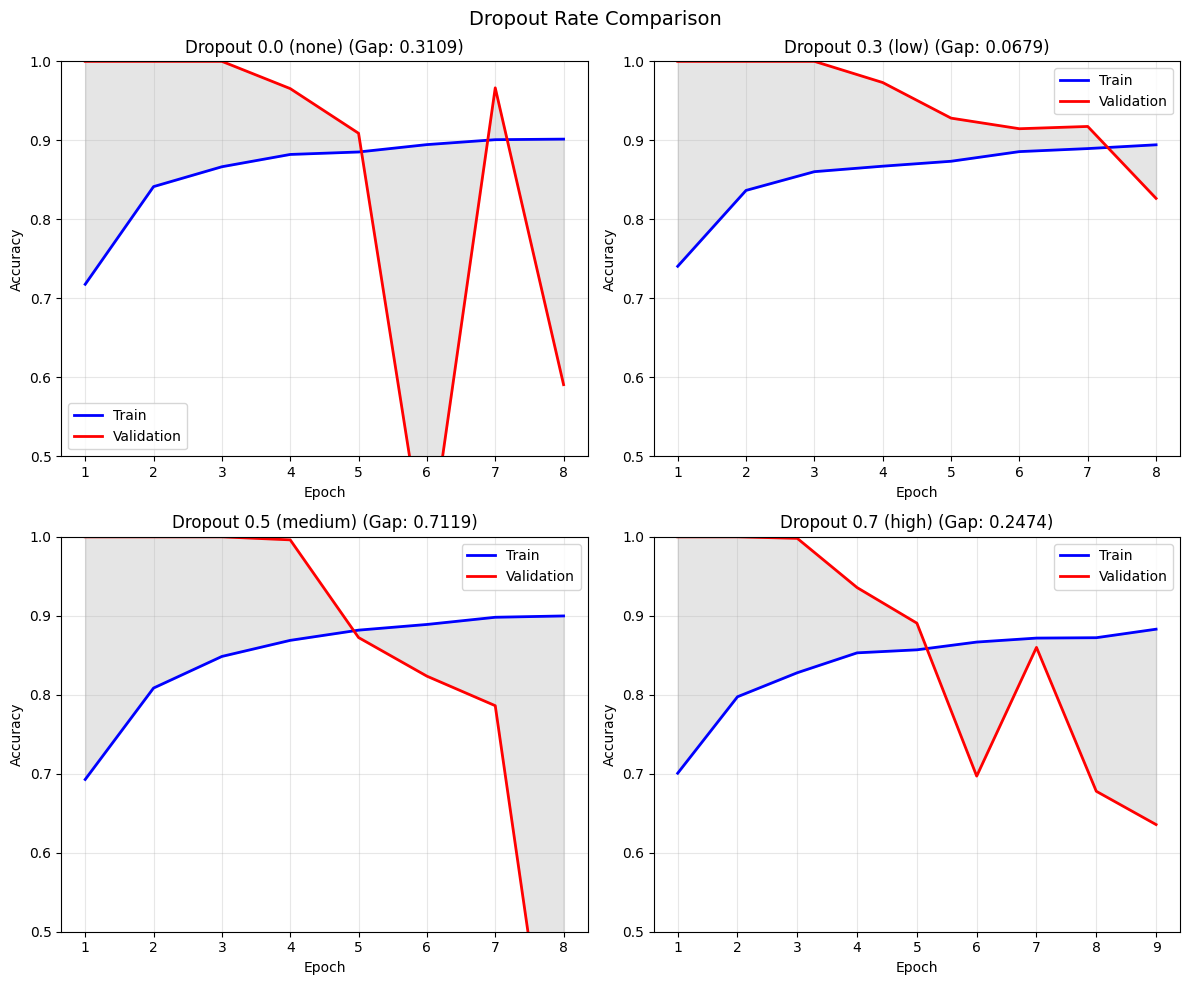

In [23]:
# Dropout comparison
dropout_exps = [r for r in all_results if 'Dropout' in r['name']]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Dropout Rate Comparison', fontsize=14)

for idx, exp in enumerate(dropout_exps):
    ax = axes[idx // 2, idx % 2]
    history = exp['history']
    epochs_range = range(1, len(history['accuracy']) + 1)
    
    ax.plot(epochs_range, history['accuracy'], 'b-', label='Train', linewidth=2)
    ax.plot(epochs_range, history['val_accuracy'], 'r-', label='Validation', linewidth=2)
    ax.fill_between(epochs_range, history['accuracy'], history['val_accuracy'], alpha=0.2, color='gray')
    
    ax.set_title(f"{exp['name']} (Gap: {exp['overfit_gap']:.4f})")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('dropout_comparison.png', dpi=150)
plt.show()

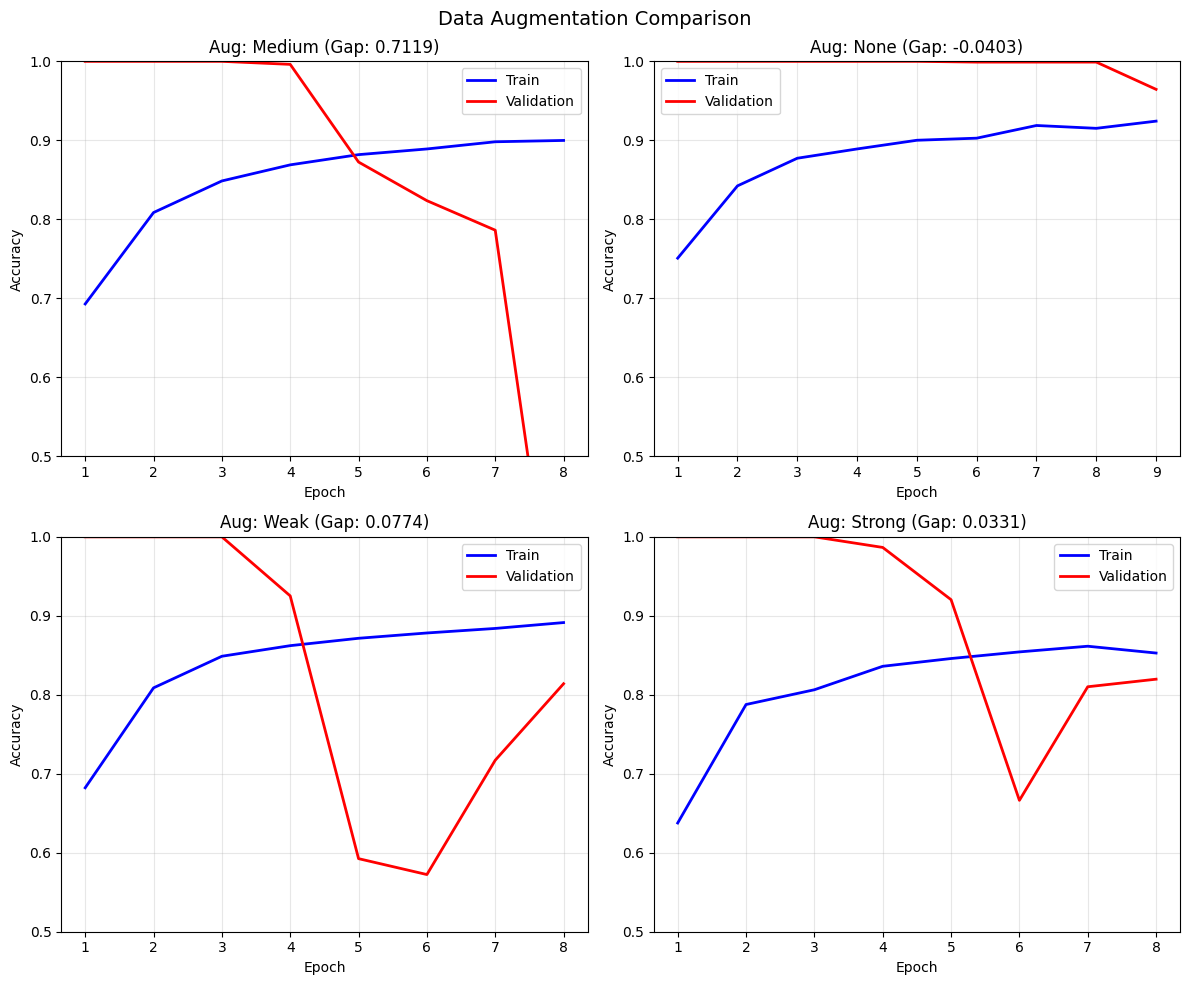

In [31]:
# Augmentation comparison
aug_exps = [r for r in all_results if 'Aug:' in r['name']]
baseline = next((r for r in all_results if 'Dropout 0.5' in r['name']), None)
if baseline:
    aug_exps = [{'name': 'Aug: Medium', **{k:v for k,v in baseline.items() if k != 'name'}}] + aug_exps

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Data Augmentation Comparison', fontsize=14)

for idx, exp in enumerate(aug_exps[:4]):
    ax = axes[idx // 2, idx % 2]
    history = exp['history']
    epochs_range = range(1, len(history['accuracy']) + 1)
    
    ax.plot(epochs_range, history['accuracy'], 'b-', label='Train', linewidth=2)
    ax.plot(epochs_range, history['val_accuracy'], 'r-', label='Validation', linewidth=2)
    
    ax.set_title(f"{exp['name']} (Gap: {exp['overfit_gap']:.4f})")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('augmentation_comparison.png', dpi=150)
plt.show()

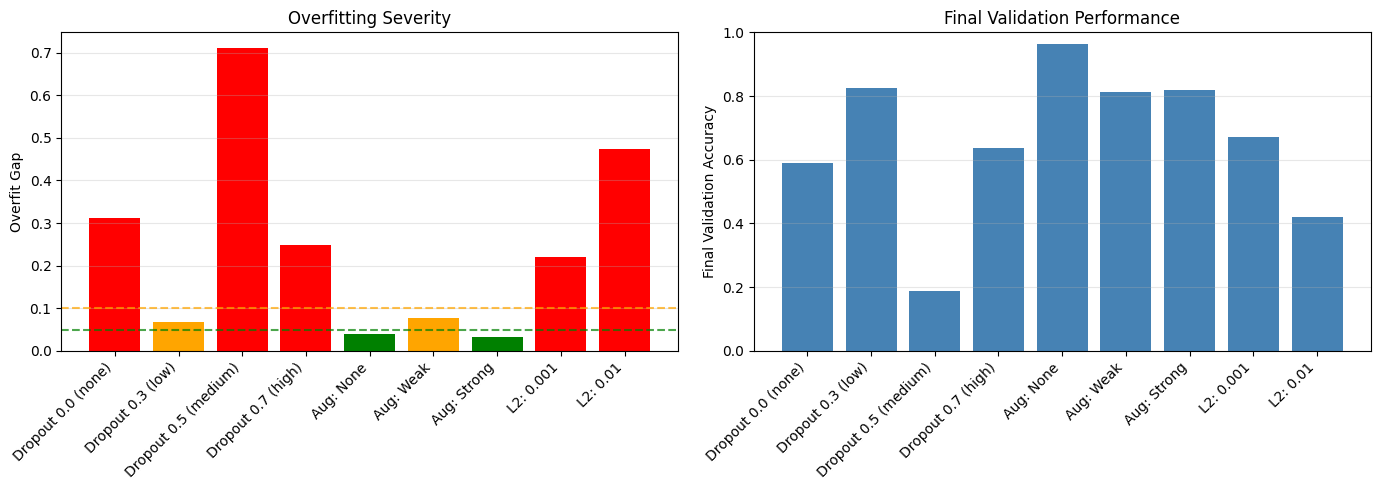

In [47]:
# Remove duplicate
all_results = [r for r in all_results if r['name'] != 'Aug: Medium']

# Summary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

names = [r['name'] for r in all_results]
gaps = [abs(r['overfit_gap']) for r in all_results]
colours = ['green' if g < 0.05 else 'orange' if g < 0.1 else 'red' for g in gaps]

ax1.bar(range(len(names)), gaps, color=colours)
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels(names, rotation=45, ha='right')
ax1.set_ylabel('Overfit Gap')
ax1.set_title('Overfitting Severity')
ax1.axhline(y=0.05, color='green', linestyle='--', alpha=0.7)
ax1.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7)
ax1.grid(True, alpha=0.3, axis='y')

val_accs = [r['final_val_acc'] for r in all_results]
ax2.bar(range(len(names)), val_accs, color='steelblue')
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels(names, rotation=45, ha='right')
ax2.set_ylabel('Final Validation Accuracy')
ax2.set_title('Final Validation Performance')
ax2.set_ylim([0.0, 1.0])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('all_experiments_summary.png', dpi=150)
plt.show()

## Best Dropout Configuration

In [51]:
dropout_experiments = [r for r in all_results if 'Dropout' in r['name']]

# Filter for positive gaps, then find smallest
positive_gap_exps = [e for e in dropout_experiments if e['overfit_gap'] > 0]
if positive_gap_exps:
    best_exp = min(positive_gap_exps, key=lambda x: (x['overfit_gap'], -x['final_val_acc']))
else:
    best_exp = min(dropout_experiments, key=lambda x: abs(x['overfit_gap']))

print("Best dropout configuration:")
print(f"  Experiment: {best_exp['name']}")
print(f"  Dropout: {best_exp['dropout']}")
print(f"  Augmentation: {best_exp['augmentation']}")
print(f"  L2: {best_exp['l2_reg']}")
print(f"  Val Accuracy: {best_exp['final_val_acc']:.4f}")
print(f"  Overfit Gap: {best_exp['overfit_gap']:.4f}")

Best dropout configuration:
  Experiment: Dropout 0.3 (low)
  Dropout: 0.3
  Augmentation: medium
  L2: 0.0
  Val Accuracy: 0.8265
  Overfit Gap: 0.0679


In [52]:
# Test set evaluation with recommended configuration
best_model = build_model(
    dropout_rate=0.3,
    augmentation_strength='strong',
    l2_reg=0.0
)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

print("\nTest set results:")
test_results = best_model.evaluate(test_ds)
for name, value in zip(best_model.metrics_names, test_results):
    print(f"  {name}: {value:.4f}")

Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 307ms/step - accuracy: 0.7261 - auc: 0.7869 - loss: 0.5649 - precision: 0.8713 - recall: 0.7381 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.3891 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 308ms/step - accuracy: 0.8100 - auc: 0.8945 - loss: 0.4095 - precision: 0.9594 - recall: 0.7754 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.1271 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 318ms/step - accuracy: 0.8248 - auc: 0.9094 - loss: 0.3739 - precision: 0.9576 - recall: 0.7981 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0559 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 316ms/step - accuracy: 0.8440 - auc: 0.9169 - loss: 0.3527 - precision: 0.9684 - recall: 0.8153 - val_accuracy: 0.9386 - val_auc: 0.0000e+00 - val_loss: 0.1412 - val_precision: 1.0000 - val_recall: 0.9386
Epoc

## Analysis Summary

In [50]:
print("DROPOUT RESULTS:")
dropout_exps = [r for r in all_results if 'Dropout' in r['name']]
for exp in dropout_exps:
    print(f"  {exp['name']}: Gap={exp['overfit_gap']:.4f}, Val={exp['final_val_acc']:.4f}")
# Best = smallest gap among experiments with val_acc > 0.7
valid_dropout = [e for e in dropout_exps if e['final_val_acc'] > 0.7]
if valid_dropout:
    best_dropout = min(valid_dropout, key=lambda x: abs(x['overfit_gap']))
else:
    best_dropout = max(dropout_exps, key=lambda x: x['final_val_acc'])
print(f"  → Best: {best_dropout['name']}")

print("\nAUGMENTATION RESULTS:")
aug_exps = [r for r in all_results if 'Aug:' in r['name']]
# Add medium baseline from dropout experiments for comparison
baseline = next((r for r in all_results if 'Dropout 0.5' in r['name']), None)
if baseline and not any(e['name'] == 'Aug: Medium' for e in aug_exps):
    aug_exps.append({'name': 'Aug: Medium', 'augmentation': 'medium', 
                     'overfit_gap': baseline['overfit_gap'], 'final_val_acc': baseline['final_val_acc']})
for exp in aug_exps:
    print(f"  {exp['name']}: Gap={exp['overfit_gap']:.4f}, Val={exp['final_val_acc']:.4f}")
# Best = highest validation accuracy among experiments with positive gap
positive_gap_aug = [e for e in aug_exps if e['overfit_gap'] > 0]
if positive_gap_aug:
    best_aug = max(positive_gap_aug, key=lambda x: x['final_val_acc'])
else:
    best_aug = max(aug_exps, key=lambda x: x['final_val_acc'])
print(f"  → Best: {best_aug['name']}")

print("\nL2 REGULARISATION RESULTS:")
l2_exps = [r for r in all_results if 'L2:' in r['name']]
if baseline:
    l2_exps.append({'name': 'L2: 0 (baseline)', 'l2_reg': 0, 
                    'overfit_gap': baseline['overfit_gap'], 'final_val_acc': baseline['final_val_acc']})
for exp in l2_exps:
    print(f"  {exp['name']}: Gap={exp['overfit_gap']:.4f}, Val={exp['final_val_acc']:.4f}")
# Check if any L2 > 0 beats best dropout/augmentation results
best_non_l2_val = max(best_dropout['final_val_acc'], best_aug['final_val_acc'])
l2_only = [e for e in l2_exps if e.get('l2_reg', 0) > 0]
best_l2_result = max(l2_only, key=lambda x: x['final_val_acc']) if l2_only else None
l2_helped = best_l2_result and best_l2_result['final_val_acc'] > best_non_l2_val
if l2_helped:
    best_l2 = best_l2_result
    print(f"  → Best: {best_l2['name']}")
else:
    print(f"  → Best: L2: 0 (regularisation did not improve over other methods)")

print(f"\nRECOMMENDED SETTINGS FOR FINAL MODEL:")
print(f"  Dropout: {best_dropout['dropout']}")
print(f"  Augmentation: {best_aug['augmentation']}")
print(f"  L2: {best_l2_result.get('l2_reg', 0) if l2_helped else 0}")

DROPOUT RESULTS:
  Dropout 0.0 (none): Gap=0.3109, Val=0.5906
  Dropout 0.3 (low): Gap=0.0679, Val=0.8265
  Dropout 0.5 (medium): Gap=0.7119, Val=0.1879
  Dropout 0.7 (high): Gap=0.2474, Val=0.6357
  → Best: Dropout 0.3 (low)

AUGMENTATION RESULTS:
  Aug: None: Gap=-0.0403, Val=0.9645
  Aug: Weak: Gap=0.0774, Val=0.8140
  Aug: Strong: Gap=0.0331, Val=0.8198
  Aug: Medium: Gap=0.7119, Val=0.1879
  → Best: Aug: Strong

L2 REGULARISATION RESULTS:
  L2: 0.001: Gap=0.2208, Val=0.6702
  L2: 0.01: Gap=0.4732, Val=0.4199
  L2: 0 (baseline): Gap=0.7119, Val=0.1879
  → Best: L2: 0 (regularisation did not improve over other methods)

RECOMMENDED SETTINGS FOR FINAL MODEL:
  Dropout: 0.3
  Augmentation: strong
  L2: 0
